In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define a bandit environment
class Bandit:
    def __init__(self, k_arm=10, true_reward=0.0):
        self.k = k_arm
        self.true_reward = true_reward
        self.actions_values = None
        self.best_action = None

    def reset(self):    # reset the bandit with new true action values
        self.actions_values = np.random.randn(self.k) + self.true_reward
        self.best_action = np.argmax(self.actions_values)

    def pull(self, action: int) -> float:    # pull an arm, return stochastic reward
        return np.random.randn() + self.actions_values[action]

# define an agent using epsilon-greedy
class Agent:
    def __init__(self, k_arm=10, epsilon=0.0, sample_averages=True,
                 q_init=0.0, step_size=None):   # added q_init + step_size
        self.k = k_arm
        self.epsilon = epsilon
        self.sample_averages = sample_averages
        self.q_init = q_init                    # store optimistic initialization value
        self.step_size = step_size              # allow constant step-size
        self.q_estimation = None
        self.action_count = None
        self.available_actions = np.arange(self.k)

    def reset(self):
        self.q_estimation = np.full(self.k, self.q_init, dtype=float)
        self.action_count = np.zeros(self.k, dtype=float)

    def act(self) -> int:   # choose action using epsilon-greedy
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.available_actions)
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def learn(self, action: int, reward: float):
        self.action_count[action] += 1
        # choose alpha dynamically
        if self.sample_averages and self.step_size is None:
            alpha = 1.0 / self.action_count[action]
        else:
            alpha = self.step_size if self.step_size is not None else 0.0
        # apply update rule
        if alpha > 0.0:
            self.q_estimation[action] += alpha * (reward - self.q_estimation[action])

class UCBAgent:
    def __init__(self, k_arm=10, c=2.0, step_size=None):
        self.k = k_arm
        self.c = c
        self.step_size = step_size
        self.q_estimation = None
        self.action_count = None
        self.t = 0

    def reset(self):
        self.q_estimation = np.zeros(self.k, dtype=float)
        self.action_count = np.zeros(self.k, dtype=float)
        self.t = 0

    def act(self) -> int:
        self.t += 1
        untried = np.where(self.action_count == 0)[0]
        if len(untried) > 0:
            return np.random.choice(untried)
        bonus = self.c * np.sqrt(np.log(self.t) / self.action_count)
        ucb = self.q_estimation + bonus
        u = np.max(ucb)
        return np.random.choice(np.where(ucb == u)[0])

    def learn(self, action: int, reward: float):
        self.action_count[action] += 1
        alpha = 1.0 / self.action_count[action] if self.step_size is None else self.step_size
        self.q_estimation[action] += alpha * (reward - self.q_estimation[action])

def simulate(runs, time, agents, envs):
    rewards = np.zeros((len(agents), runs, time))   # reward log
    best_action_counts = np.zeros_like(rewards)     # optimal action log

    for i, (agent, env) in enumerate(zip(agents, envs)):
        for r in range(runs):
            env.reset(); agent.reset()
            for t in range(time):
                action = agent.act()            # pick action
                reward = env.pull(action)       # get reward
                agent.learn(action, reward)     # update estimate
                rewards[i, r, t] = reward       # record reward
                best_action_counts[i, r, t] = (action == env.best_action)

    return best_action_counts.mean(axis=1), rewards.mean(axis=1) # averages

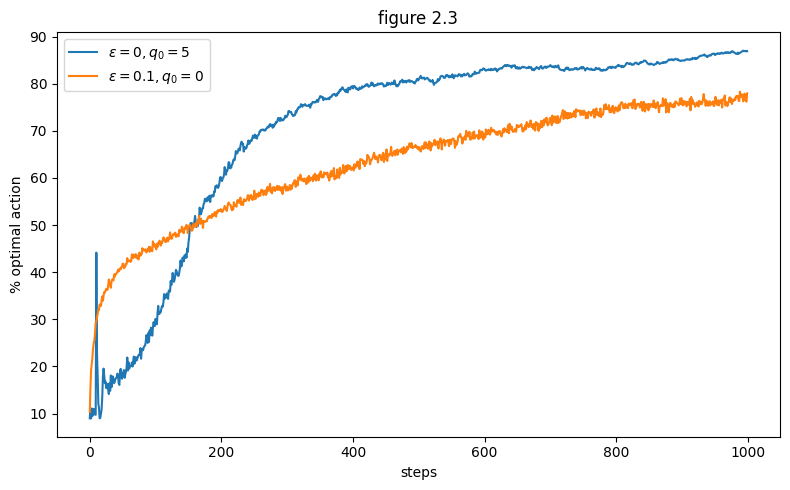

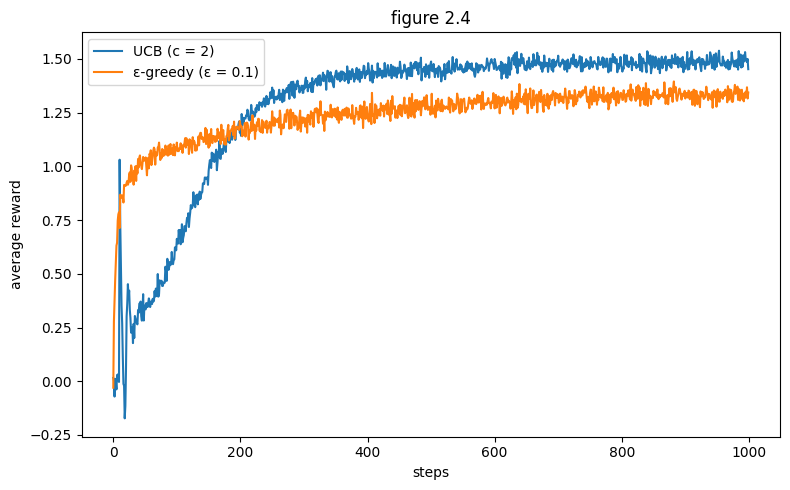

In [17]:
runs = 2000
steps = 1000

bandits = [
    Agent(k_arm=10, epsilon=0.0, sample_averages=False, q_init=5.0, step_size=0.1),
    Agent(k_arm=10, epsilon=0.1, sample_averages=False, q_init=0.0, step_size=0.1),
]
envs = [Bandit(k_arm=10, true_reward=0.0) for _ in bandits]

best_action_counts, average_rewards = simulate(runs, steps, bandits, envs)

# figure 2.3
plt.figure(figsize=(8, 5))
plt.plot(100 * best_action_counts[0], label=r"$\epsilon = 0, q_0 = 5$")
plt.plot(100 * best_action_counts[1], label=r"$\epsilon = 0.1, q_0 = 0$")
plt.xlabel("steps")
plt.ylabel("% optimal action")
plt.title("figure 2.3")
plt.legend()
plt.tight_layout()
plt.show()

# figure 2.4
bandits = [
    UCBAgent(k_arm=10, c=2.0, step_size=None),
    Agent(k_arm=10, epsilon=0.1, sample_averages=True, q_init=0.0, step_size=None),
]
envs = [Bandit(k_arm=10, true_reward=0.0) for _ in bandits]

plt.figure(figsize=(8, 5))
plt.plot(average_rewards[0], label="UCB (c = 2)")
plt.plot(average_rewards[1], label=r"ε-greedy (ε = 0.1)")
plt.xlabel("steps")
plt.ylabel("average reward")
plt.title("figure 2.4")
plt.legend()
plt.tight_layout()
plt.show()